In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import re
import datetime
from missingno import matrix

In [314]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

In [315]:
# Rain gauge metadata
df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')

# Rain gauges - Review processing of this data before proceeding 
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
gauges_raw_hour = gauges_raw.resample('1h').sum().rename(lambda x : str(x) + '_R_raw',axis=1)

# Processed rain gauge data
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean = gauges_clean.rename(lambda x : str(x) + '_R_manual',axis=1)

# All rain gauge data 
gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)
first_non_0 = gauges.fillna(0).apply(lambda x : np.argwhere(x.values != 0)[0])
gauges = gauges.apply(lambda x : x.iloc[first_non_0.loc[:,x.name][0]:])  

# Remove rediculous outliers (53 is larges in manual dataset)
gauges[gauges.values > 55]= np.nan

# other variables
df_temperature =  pd.read_pickle('../Rainfall - runoff/temperature_data.pkl')
df_temperature = df_temperature.rename(lambda x : str(x) + '_T',axis=1)

# Drainage flow data
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
df_target = df_target.drop(['MOS-HOL','KOP-HAB'],axis=1)


In [316]:
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2020,12,31,23,59,59)


In [317]:
gauges

,1473_R_raw,1474_R_raw,1475_R_raw,1478_R_raw,1481_R_raw,1482_R_raw,1485_R_raw,1578_R_raw,1473_R_manual,1474_R_manual,1475_R_manual,1478_R_manual,1485_R_manual
TIMI,,,,,,,,,,,,,
2005-08-22 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03 09:00:00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN
2021-06-03 10:00:00,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.20,NaN,NaN,NaN,NaN,NaN
2021-06-03 11:00:00,0.0,0.0,0.60,0.0,0.0,0.0,0.0,0.20,NaN,NaN,NaN,NaN,NaN


# We use 1475_R_manual to select the top 1000 rainy days from and including 2015 based on total daily rainfall

In [323]:
# g = gauges.loc[d_start:d_end,['1475_R_manual','1485_R_manual']]
g = gauges.loc[d_start:d_end,'1475_R_manual']

<AxesSubplot:>

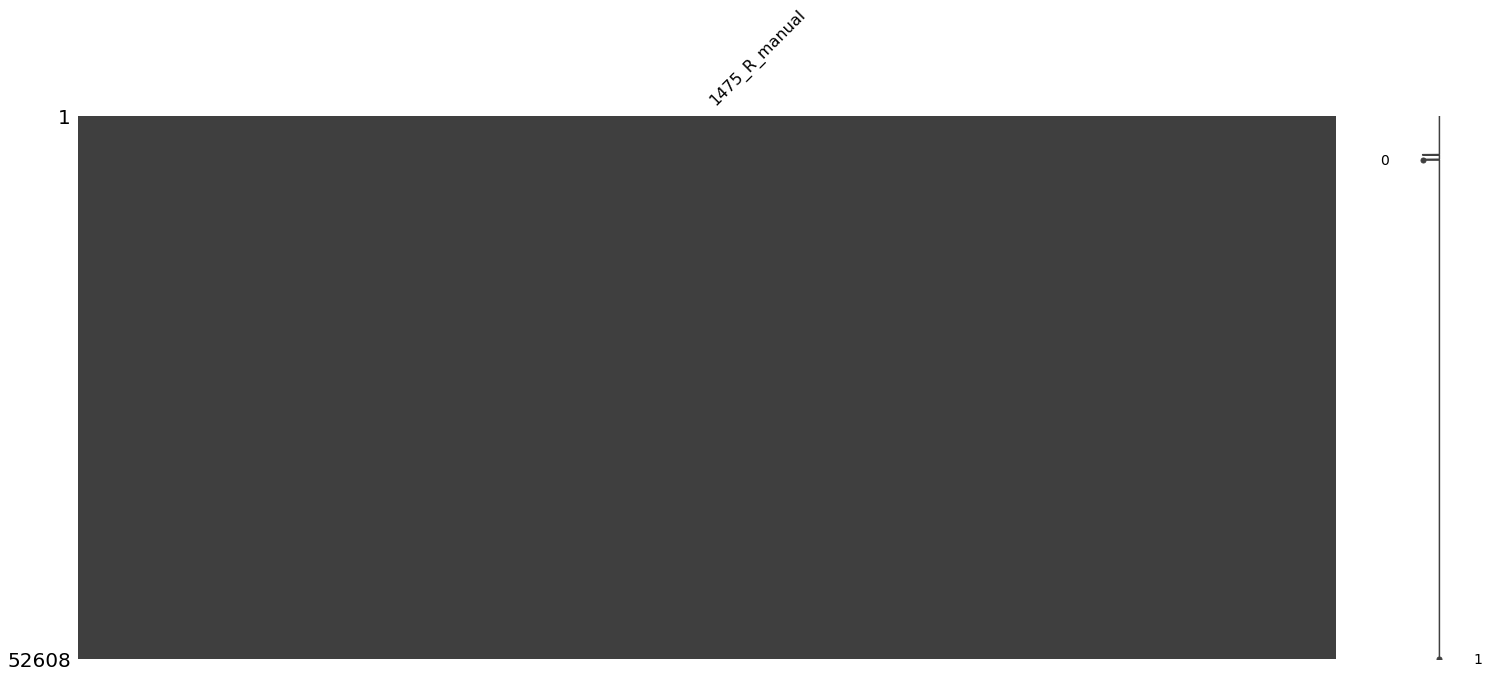

In [324]:
matrix(pd.DataFrame(g))

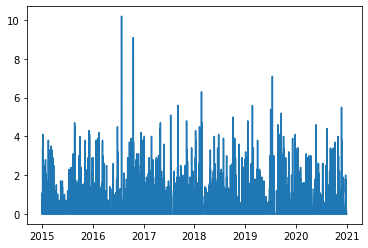

In [325]:
plt.plot(g)

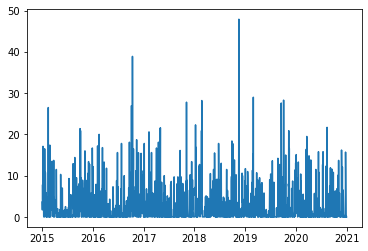

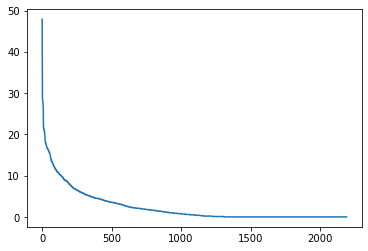

In [327]:
g_daily = g.resample('1d').sum()
g_daily_sorted = g_daily.sort_values()
plt.plot(g_daily)
plt.show()
plt.plot(g_daily_sorted.values[::-1])
plt.show()

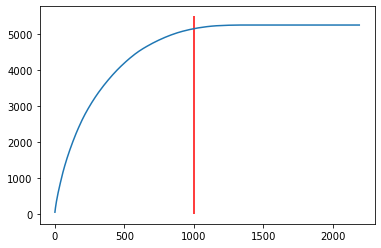

In [331]:
plt.plot(np.cumsum(g_daily_sorted.values[::-1]))
plt.vlines(1000,0,5500,color='r')

In [335]:
drainage_flow_daily_mean = df_target.resample('1d').mean()#*24
drainage_flow_daily_min = df_target.resample('1d').min()#*24
drainage_flow_daily_max = df_target.resample('1d').max()#*24
g_daily_1000 = g_daily.sort_values()[::-1][:1000]

In [332]:
rainfall_bins = [(0,0.5),(0.5,2),(2,5),(5,10),(10,30),(30,100)]
gs = []
for low,high in rainfall_bins:
    g_sub = g_daily[((g_daily<high) & (g_daily >= low))]
    gs.append(len(g_sub))
gs = np.array(gs)
print((gs/len(g_daily)).round(2).tolist())

[0.5, 0.17, 0.17, 0.1, 0.06, 0.0]


In [336]:
drainage_daily_sorted_mean = drainage_flow_daily_mean.loc[d_start:d_end,'RVK-GEL'].sort_values()
drainage_daily_sorted_min = drainage_flow_daily_min.loc[d_start:d_end,'RVK-GEL'].sort_values()
drainage_daily_sorted_max = drainage_flow_daily_max.loc[d_start:d_end,'RVK-GEL'].sort_values()

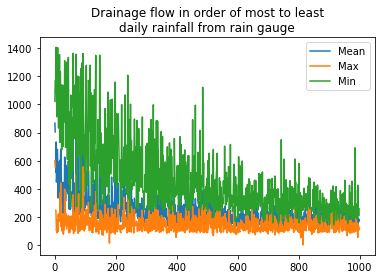

In [345]:
plt.plot(drainage_daily_sorted_mean.loc[g_daily_1000.index].values)
plt.plot(drainage_daily_sorted_min.loc[g_daily_1000.index].values)
plt.plot(drainage_daily_sorted_max.loc[g_daily_1000.index].values)
plt.legend(['Mean','Max','Min'])
plt.title('Drainage flow in order of most to least\ndaily rainfall from rain gauge')
plt.show()

In [340]:
# plt.plot(drainage_daily_sorted.values[::-1])

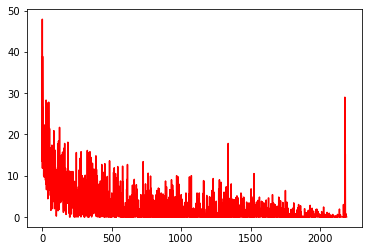

In [309]:
# plt.plot(drainage_daily_sorted.values[::-1])
plt.plot(g_daily_sorted.loc[drainage_daily_sorted.index].values[::-1],c='r')

In [310]:
baseline = g_daily_sorted.values[::-1]*13000/50 + 2500
residual = drainage_flow_daily.loc[g_daily_sorted.index[::-1],'RVK-GEL'].values - baseline

In [312]:
[(col,g_daily_sorted.corr(drainage_flow_daily.loc[g_daily_1000.index[::-1],col])) for col in drainage_flow_daily]

[('RVK-SEI', 0.18707699974523948),
 ('RVK-BOD', 0.4122235973560834),
 ('RVK-VES', 0.30702828336976423),
 ('RVK-SKE', 0.23505424037615574),
 ('RVK-FAX', 0.20433925196244537),
 ('RVK-ANA', 0.28624928634986074),
 ('RVK-ING', 0.29244391232273714),
 ('RVK-LAU', 0.4839880621927418),
 ('RVK-GUF', 0.24236876537297508),
 ('RVK-GEL', 0.6686198469875975),
 ('RVK-KLE', 0.2884290594692998)]